# 14. 自适应滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

# 简介

到目前为止，我们考虑的是跟踪相对于我们的过程模型行为良好的对象的问题。例如，我们可以使用恒定速度滤波器来跟踪沿直线运动的对象。只要对象在直线上以相当恒定的速度运动，或者轨迹和/或速度变化得非常缓慢，这个滤波器将表现得非常好。但假设我们要跟踪的是一个机动目标，比如在道路上行驶的汽车、飞行中的飞机等等。在这些情况下，滤波器的性能会相当差。另外，考虑一种情况，比如在海洋中追踪一艘帆船。即使我们对控制输入进行建模，我们也无法对风或洋流进行建模。

解决这个问题的一种初步方法是增大过程噪声$\mathbf{Q}$，以考虑系统动态的不可预测性。虽然这可以使滤波器不会发散，但结果通常远非最优。更大的$\mathbf{Q}$会导致滤波器更加关注测量中的噪音。我们很快将看到一个例子。

在本章中，我们将讨论*自适应滤波器*的概念。当滤波器检测到过程模型无法解释的动态时，该滤波器将*自适应*调整自己。我将从问题的一个示例开始，然后讨论并实现各种自适应滤波器。

# 机动目标

我们需要一个机动目标的模拟。我会实现一个简单的二维模型，加入操控输入。你提供新的速度和/或方向，它会修改自身状态以匹配新的要求。

In [3]:
from math import sin, cos, radians

def angle_between(x, y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
    
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
         
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0    

现在我们来实现一个带有噪音的模拟传感器。

In [4]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

现在让我们生成一条轨迹并将其绘制出来，以测试所有功能是否正常运行。我会将数据生成放入一个函数中，这样我们就可以创建不同长度的路径（为什么会很快明白）。

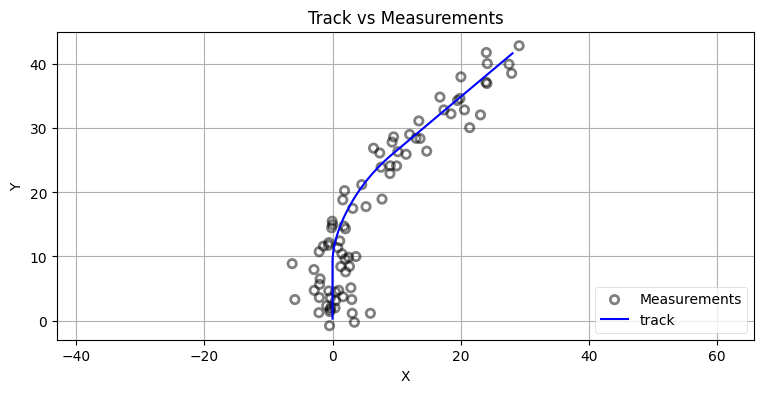

In [5]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

这么多噪音能让我们更容易看到各种设计选择的效果。

现在我们可以实现一个卡尔曼滤波器来追踪这个对象。但是让我们进行简化。 *x* 和 *y* 坐标是独立的，因此我们可以分别跟踪每个坐标。在本章的其余部分，我们只会跟踪 *x* 坐标，以尽可能保持代码和矩阵的简洁。

我们从一个恒定速度滤波器开始。

In [8]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

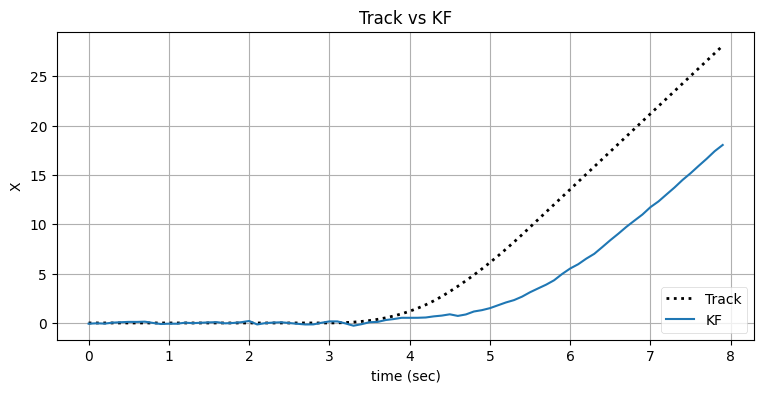

In [9]:
sensor_std = 2.
dt = 0.1

# initialize filter
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

# run it
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

# plot results
bp.plot_track(track[:, 0], dt=dt)
bp.plot_filter(kxs[:, 0], dt=dt, label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);

从图中可以看出，卡尔曼滤波器无法跟踪航向的变化。回想一下**g-h Filter**章节，这是因为滤波器没有建模加速度，因此它总是会落后于输入。如果信号进入稳定状态，滤波器最终会赶上信号。我们来看一下这个情况。

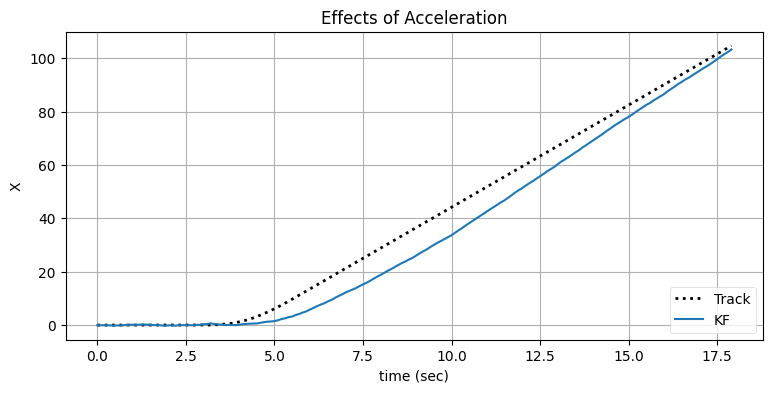

In [10]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)

track2, zs2 = generate_data(150, sensor_std)
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]

kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', 
              x='time (sec)', y='X')

根本问题在于我们的过程模型对于稳态部分是正确的，但对于物体机动时是不正确的。我们可以尝试通过增加 Q 的大小来解决这个问题，就像这样。

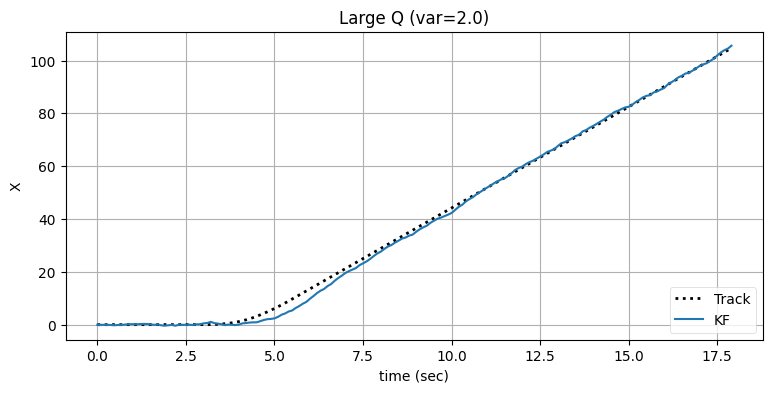

In [11]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=2.0)
track, zs = generate_data(50, sensor_std)

# recompute track
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)
bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Large Q (var=2.0)', x='time (sec)', y='X')


我们可以看到，滤波器更快地重新跟踪到轨迹，但输出中出现了大量的噪音。此外，在4秒到8秒之间显示的滞后量在许多跟踪情况下是无法容忍的。我们可以进一步减少这种滞后，但会以非常嘈杂的输出为代价，就像这样：

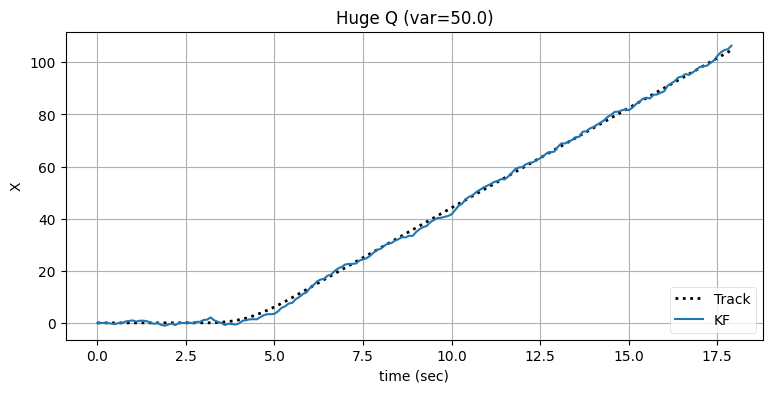

In [12]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=50.0)
track, zs = generate_data(50, sensor_std)

# recompute track
cvfilter.x.fill(0.)
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=50.0)', x='time (sec)', y='X')

机动意味着加速度，所以让我们实现一个恒定加速度的卡尔曼滤波器，看看它在相同数据下的表现如何。

In [13]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt],
                           [0, 1,         dt], 
                           [0, 0,          1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0., 0., 0.])
    f.P = np.eye(3) * 3

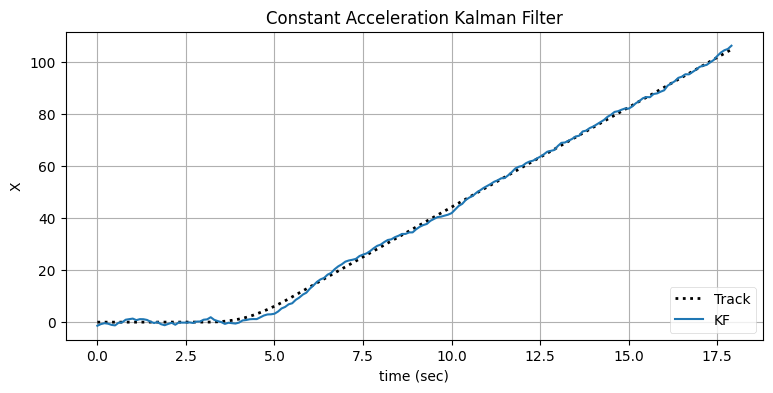

In [14]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceleration Kalman Filter',
              x='time (sec)', y='X')

恒定加速度模型能够在没有滞后的情况下跟踪机动，但在稳定状态下表现出非常嘈杂的输出。嘈杂的输出是由于滤波器无法区分机动的开始和信号中的噪音。信号中的噪音意味着加速度，因此滤波器的加速度项也在追踪它。

看起来我们无法取得胜利。恒定速度滤波器在目标加速时无法迅速反应，而恒定加速度滤波器则将零加速度时的噪音误解为加速度。

然而，这里有一个重要的见解会引导我们找到解决方案。当目标没有进行机动（加速度为零）时，恒定速度滤波器表现最佳。当目标进行机动时，恒定加速度滤波器表现良好，与人为设定的较大过程噪声 $\mathbf{Q}$ 的恒定速度滤波器一样。如果我们制作一个能够根据被跟踪对象的行为自适应的滤波器，我们就能兼具两种滤波器的优点。

# 检测机动

在讨论如何创建自适应滤波器之前，我们必须问：“我们如何检测机动？”如果我们不知道何时发生机动，我们就无法合理地使滤波器适应响应机动。

我们一直将 *机动* 定义为被跟踪对象正在加速的时间，但一般来说，如果对象的行为与滤波器使用的过程模型不同，我们可以说该对象在相对于卡尔曼滤波器进行机动。

对于滤波器来说，机动对象的数学结果是什么？对象的行为将与滤波器预测的行为不同，因此残差会很大。回想一下，残差是滤波器当前预测值与测量值之间的差异。

<img src="./figs/residual_chart.png">

为了确认这一点，让我们绘制在机动期间滤波器的残差。我会减少数据中的噪音，以便更容易观察残差。

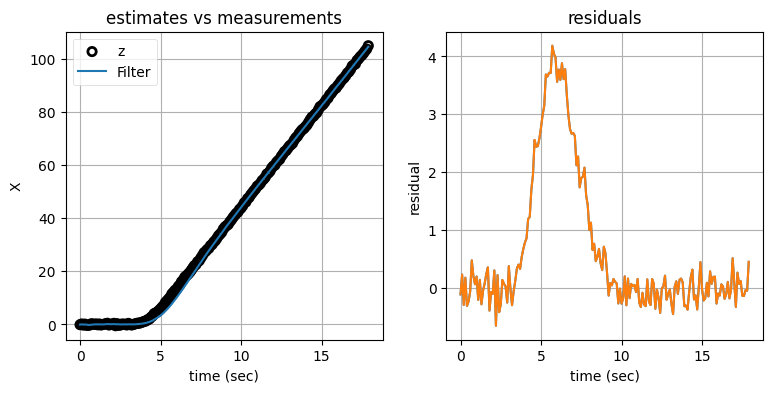

In [15]:
from kf_book.adaptive_internal import plot_track_and_residuals

def show_residual_chart():
    dt = 0.1
    sensor_std = 0.2
    
    # initialize filter
    cvfilter = make_cv_filter(dt, sensor_std)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(150, sensor_std)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs, res = [], []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(dt, xs, z_xs2, res)

show_residual_chart();

左边的图显示了嘈杂的测量值与卡尔曼滤波器输出之间的对比。右边显示了滤波器计算出的残差，即测量值与卡尔曼滤波器预测之间的差异。让我强调一下以确保清晰。右边的图不仅仅是左边图中两条线的差异。左边的图显示了测量值与最终卡尔曼滤波器输出之间的差异，而右边的图显示了测量值与*过程模型预测值*之间的差异。

这可能看起来是一个微妙的区别，但从图中可以看出并不是如此。当机动开始时，左图中的偏差量很小，但右图中的偏差告诉了我们不同的故事。如果被跟踪对象按照过程模型移动，残差图应该在0.0周围波动。这是因为测量值将遵循以下方程：

$$\text{测量值} = \text{过程模型}(t) + \text{噪音}(t)$$

一旦目标开始机动，目标行为的预测将不符合该行为，因为方程将变为：

$$\text{测量值} = \text{过程模型}(t) + \text{机动增量}(t) + \text{噪音}(t)$$

因此，如果残差偏离了平均值0.0，我们就知道机动已经开始。

从残差图中我们可以看出，我们有很多工作要做。我们可以清楚地在残差图中看到机动的结果，但信号中的噪音量掩盖了机动的开始。这就是我们长期以来需要从噪音中提取信号的问题。

# 可调过程噪音

我们将首先考虑的方法是使用较低阶的模型，并根据机动的发生情况调整过程噪音。当残差变得“大”（根据某种合理的定义）时，我们将增加过程噪音。这将使滤波器更偏向于测量值而不是过程预测，并且滤波器将更密切地跟踪信号。当残差变小时，我们将减少过程噪音。

文献中有许多这样做的方法，我将考虑其中的一些选择。

# 持续调整

第一种方法（来自Bar-Shalom [1]）使用以下方程对残差的平方进行归一化：

$$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$$

其中 $\mathbf{y}$ 是残差，$\mathbf{S}$ 是系统不确定性（协方差），其方程为

$$\mathbf{S} = \mathbf{HPH^\mathsf{T}} + \mathbf{R}$$

如果用于计算的线性代数让您感到困惑，回想一下我们可以将矩阵求逆理解为除法，所以 $\epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ 可以理解为计算

$$\epsilon\approx\frac{\mathbf{y}^2}{\mathbf{S}}$$

$\mathbf{y}$ 和 $\mathbf{S}$ 都是 `filterpy.KalmanFilter` 的属性，因此实现将会很直接。

让我们看一个 $\epsilon$ 随时间变化的图。

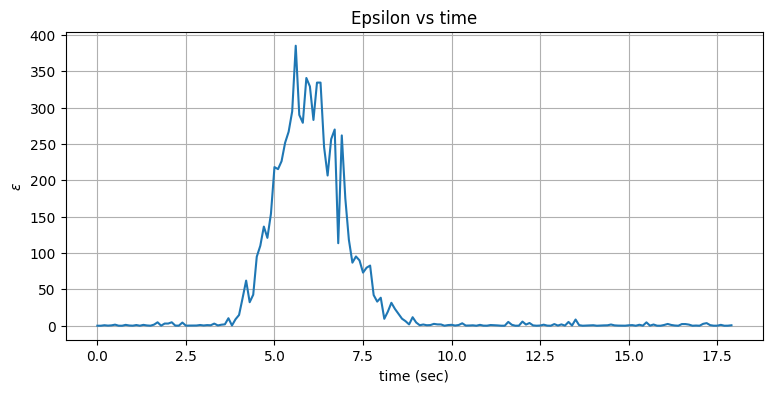

In [16]:
from numpy.linalg import inv
dt = 0.1
sensor_std = 0.2
cvfilter= make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = y.T @ inv(S) @ y
    epss.append(eps)

t = np.arange(0, len(epss) * dt, dt)
plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', 
              x='time (sec)', y='$\epsilon$')

这个图应该清楚地展示了对残差进行归一化的效果。对残差进行平方确保信号始终大于零，并且通过测量协方差的归一化，我们可以使信号按比例缩放，以便区分残差与测量噪音相比显著变化的情况。机动开始于 t=3 秒，并且我们可以看到 $\epsilon$ 在不久之后开始迅速增加。

一旦 $\epsilon$ 超过某个限制，我们将希望开始增加 $\mathbf{Q}$ 的缩放。当 $\epsilon$ 再次下降到该限制以下时，我们将希望将 $\mathbf{Q}$ 缩放还原。我们将 $\mathbf{Q}$ 乘以一个缩放因子。也许有文献可以解析地选择这个因子；我是通过实验得出的。对于 $\epsilon$ 的限制（称为 $\epsilon_{max}$），我们可以在某种程度上进行更多的分析 - 通常来说，一旦残差超过 3 个标准偏差左右，我们就可以假设差异是由于真实变化而不是噪音引起的。然而，传感器很少是真正的高斯分布，因此在实践中常用更大的数字，比如 5-6 个标准偏差。

我已经使用合理的 $\epsilon_{max}$ 和 $\mathbf{Q}$ 缩放因子来实现这个算法。为了更容易地检查结果，我将图限制在了模拟的前 10 秒内。

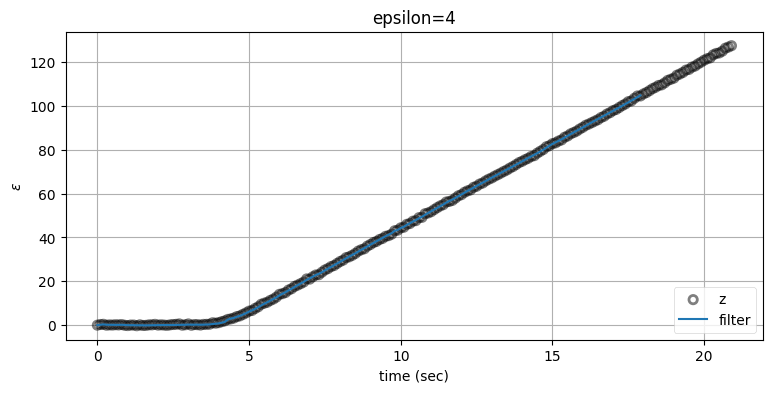

In [17]:
# reinitialize filter
dt = 0.1
sensor_std = 0.2
cvfilter = make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(180, sensor_std)

Q_scale_factor = 1000.
eps_max = 4.

xs, epss = [], []

count = 0
for i, z in zip(t, zs2[:, 0]):
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = y.T @ inv(S) @ y
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1

bp.plot_measurements(zs2[:,0], dt=dt, label='z', alpha=0.5)
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

这个滤波器的性能明显比恒定速度滤波器好得多。恒定速度滤波器在机动开始后大约花费了 10 秒才重新获取信号。而自适应滤波器只需要不到一秒就能完成相同的任务。

# 连续调整-标准差版本

另一种非常相似的方法来自 Zarchan [2]，它根据测量误差协方差的标准差来设置限制。这里的方程是：

$$ \begin{aligned}
\text{std} &= \sqrt{\mathbf{HPH}^\mathsf{T} + \mathbf{R}} \\
&= \sqrt{\mathbf{S}}
\end{aligned}
$$

如果残差的绝对值超过上述计算得到的标准差的某个倍数，我们将增加一个固定量的过程噪音，重新计算 $\mathbf{Q}$，然后继续进行滤波。

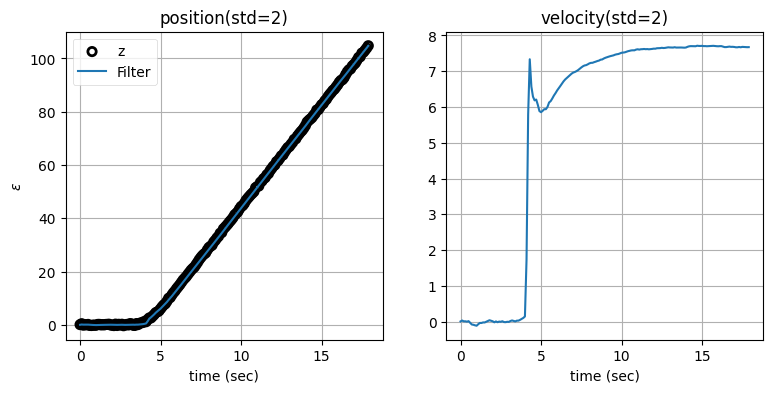

In [18]:
from math import sqrt

def zarchan_adaptive_filter(Q_scale_factor, std_scale, 
                            std_title=False,
                            Q_title=False):
    cvfilter = make_cv_filter(dt, std=0.2)
    pos2, zs2 = generate_data(180-30, std=0.2)
    xs2 = pos2[:,0]
    z_xs2 = zs2[:,0]

    # reinitialize filter
    initialize_filter(cvfilter)
    cvfilter.R = np.eye(1)*0.2

    phi = 0.02
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
    xs, ys = [], []
    count = 0
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        y = cvfilter.y
        S = cvfilter.S
        std = sqrt(S)

        xs.append(cvfilter.x)
        ys.append(y)

        if abs(y[0]) > std_scale*std:
            phi += Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count -= 1

    xs = np.asarray(xs)
    plt.subplot(121)
    bp.plot_measurements(z_xs2, dt=dt, label='z')
    bp.plot_filter(xs[:, 0], dt=dt, lw=1.5)
    bp.set_labels(x='time (sec)', y='$\epsilon$')
    plt.legend(loc=2)
    if std_title:
        plt.title(f'position(std={std_scale})')
    elif Q_title:
        plt.title(f'position(Q scale={Q_scale_factor})')
    else:
        plt.title('position')
        
    plt.subplot(122)
    plt.plot(np.arange(0, len(xs)*dt, dt), xs[:, 1], lw=1.5)
    plt.xlabel('time (sec)')
    if std_title:
        plt.title(f'velocity(std={std_scale})')
    elif Q_title:
        plt.title(f'velocity(Q scale={Q_scale_factor})')
    else:
        plt.title('velocity')        
    plt.show()
 
zarchan_adaptive_filter(1000, 2, std_title=True)

选择将噪声的缩放因子设为 1000，标准差限制设为 2。为什么选择这些数字？首先，让我们看看 2 个标准差和 3 个标准差之间的区别。

**两个标准差**

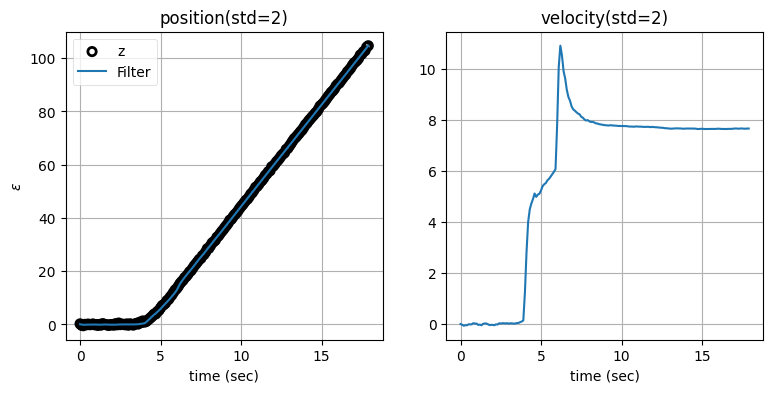

In [19]:
zarchan_adaptive_filter(1000, 2, std_title=True)

**三个标准差**

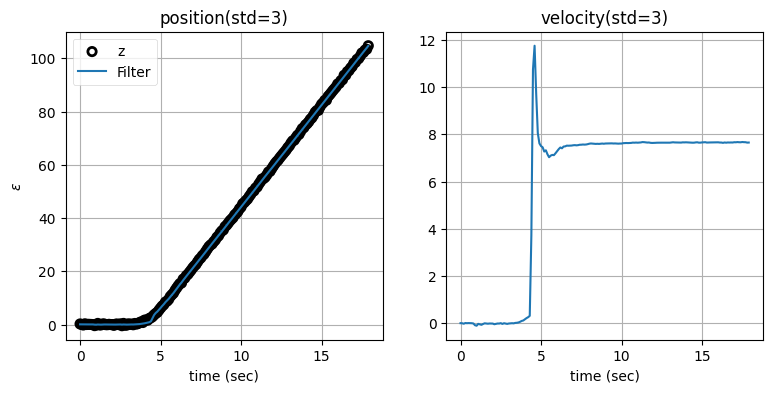

In [20]:
zarchan_adaptive_filter(1000, 3, std_title=True)

从图表中可以看出，无论我们使用 2 个标准差还是 3 个标准差，位置的滤波器输出都非常相似。但速度的计算情况就不同了。让我们进一步探讨一下。首先，让我们将标准差设得非常小。

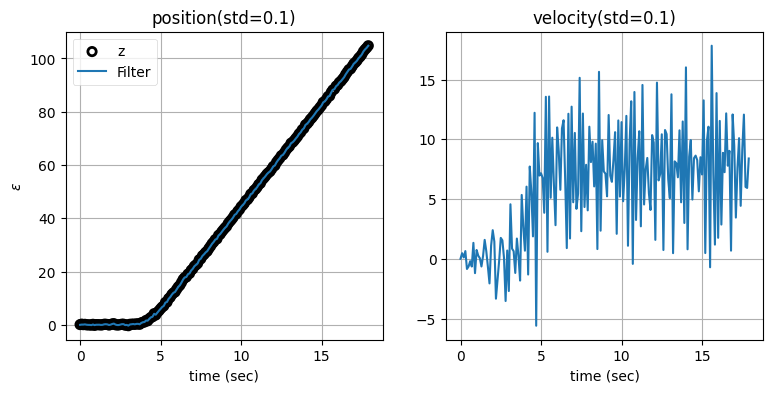

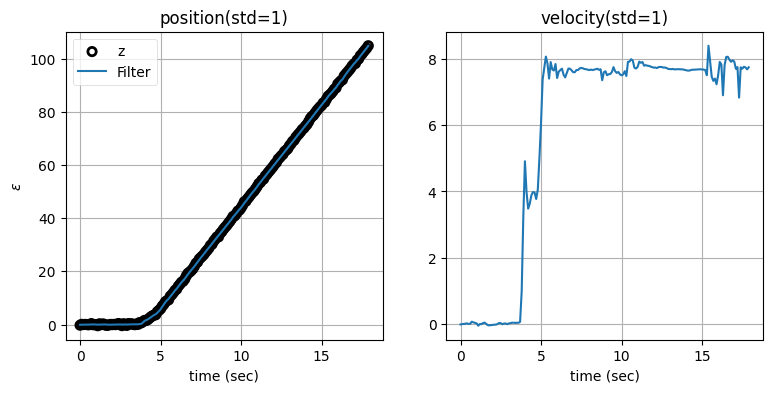

In [21]:
zarchan_adaptive_filter(1000, .1, std_title=True)
zarchan_adaptive_filter(1000, 1, std_title=True)

当标准差限制变小时，速度的计算变得更糟。想想为什么会这样。如果我们开始调整滤波器，以便即使残差与预测稍有偏差，它也更偏向于测量，我们很快就会将几乎所有的权重都赋予测量。如果没有来自预测的信息，我们就无法创建隐藏变量。因此，当限制为 0.1 个标准差时，您可以看到速度被测量中的噪音淹没。另一方面，因为我们如此偏向于测量，位置几乎完美地跟随了机动。

现在让我们看看不同增量的过程噪音会产生的影响。在这里，我将标准差限制保持在 2 个标准差，增量从 1 变化到 10,000。

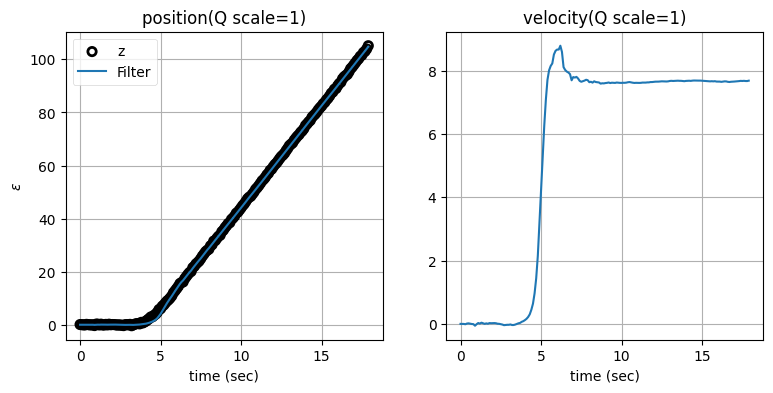

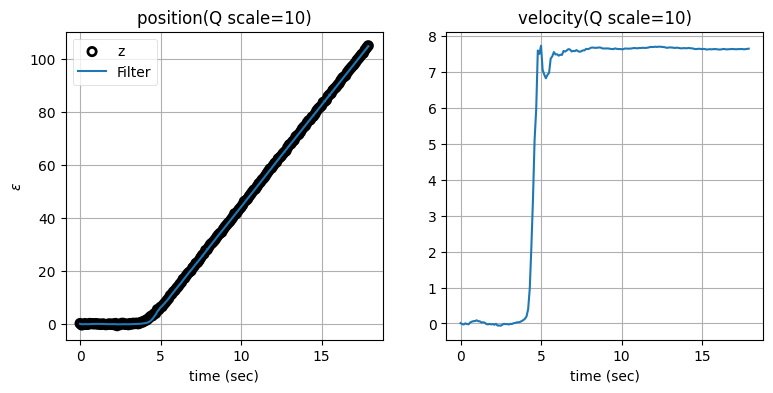

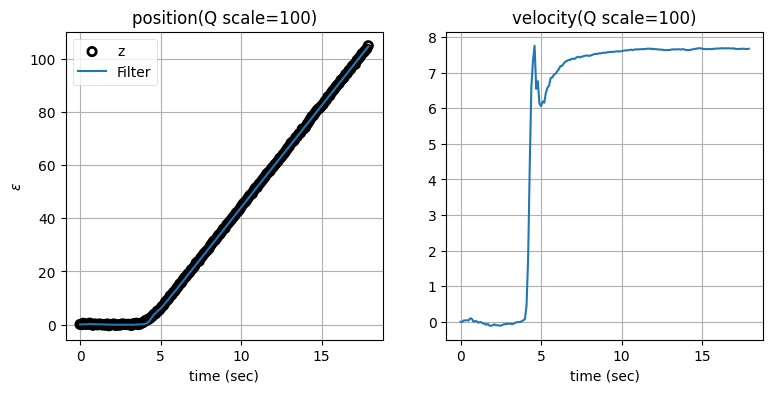

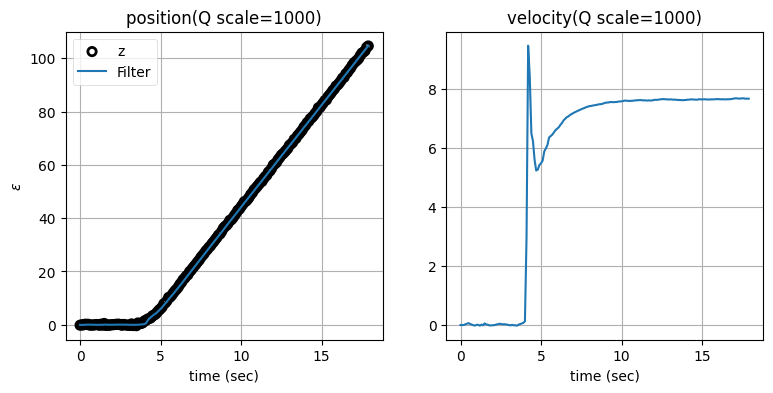

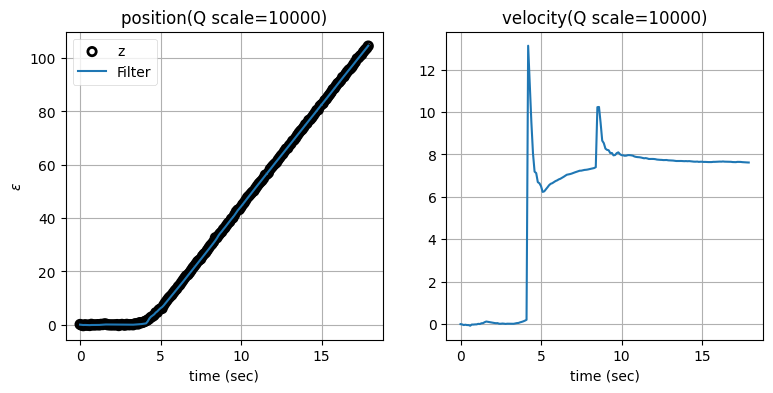

In [22]:
zarchan_adaptive_filter(1, 2, Q_title=True)
zarchan_adaptive_filter(10, 2, Q_title=True)
zarchan_adaptive_filter(100, 2, Q_title=True)
zarchan_adaptive_filter(1000, 2, Q_title=True)
zarchan_adaptive_filter(10000, 2, Q_title=True)

在这里，我们可以看到随着增量因子的增加，位置估计略有改善，但速度估计开始出现较大的过冲。

我无法告诉您哪个是“正确”的。您需要针对真实和模拟数据测试您的滤波器性能，并选择最符合您对每个状态变量所需性能的设计。

# 逐渐衰减的记忆滤波器

逐渐衰减的记忆滤波器通常不被归类为自适应滤波器，因为它们不会根据输入进行调整，但在处理机动目标时表现出良好的性能。它们还具有非常简单的计算形式，适用于一阶、二阶和三阶运动学滤波器（例如，本章中使用的滤波器）。这种简单形式不需要使用矩阵里卡蒂方程来计算卡尔曼滤波器的增益，从而大大减少了计算量。然而，也有一种形式适用于标准的卡尔曼滤波器。本章将重点介绍后者，因为我们更关注自适应滤波器。逐渐衰减记忆滤波器的两种形式均在 `FilterPy` 中实现了。

卡尔曼滤波器是递归的，但它将所有先前的测量整合到当前的滤波器增益计算中。如果目标行为与过程模型一致，这使得卡尔曼滤波器能够针对每个测量找到最佳估计。以飞行中的球为例，如果我们考虑了所有以前的测量，我们可以更清楚地估计时间 t 时球的位置。如果我们只使用了部分测量，我们对当前位置的确定性就会减少，因此更容易受到测量噪声的影响。如果还不清楚，考虑最坏的情况。假设我们忘记了除了最后一次测量和估计之外的所有内容。那么我们对位置和轨迹就没有信心，只能更加重视当前的测量。如果测量有噪声，估计结果也会有噪声。每次初始化卡尔曼滤波器时都会看到这种效应。初期的估计结果会有噪声，但随着获得更多测量，它们会稳定下来。

然而，如果目标在机动，它并不总是遵循过程模型的预测。在这种情况下，记住所有过去的测量和估计就成了一个负担。我们可以从上面的所有图表中看到这一点。目标开始转向，但卡尔曼滤波器继续在直线上预测运动。这是因为滤波器已经积累了目标的运动历史，并错误地“感觉到”目标正在按照给定的航向和速度直线运动。

逐渐衰减的记忆滤波器通过给予较旧的测量较小的权重，更多地给予最近的测量较大的权重来解决这个问题。

逐渐衰减的记忆滤波器有许多公式；我使用了丹·西蒙在《最优状态估计》[3] 中提供的其中一种。我不会详细介绍他的推导过程，只提供结果。

卡尔曼滤波器估计误差协方差的方程为

$$ \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q $$

我们可以通过乘以一个项 $\alpha$ 来强制滤波器遗忘过去的测量

$$ \tilde{\mathbf P} = \alpha^2\mathbf{FPF}^\mathsf T + \mathbf Q$$

其中 $\alpha > 1.0$。如果 $\alpha == 1$，那么我们得到正常的卡尔曼滤波器性能。$\alpha$ 是 `KalmanFilter` 类的一个属性；它的默认值为 1，所以该滤波器的行为类似于卡尔曼滤波器，除非给 $\alpha$ 赋值不等于 1 的值。对于选择 $\alpha$ 没有硬性规定，但通常非常接近 1，例如 1.01。您需要使用模拟数据或真实数据进行多次运行，以确定一个可以对机动做出响应但又不会由于过度权衡嘈杂测量而使估计结果变得过于嘈杂的值。

这为什么有效呢？如果增加估计误差协方差，滤波器对估计的不确定性就会增加，因此会更多地依赖测量。

一个注意事项——如果我们使用了 $\alpha$，那么我们计算的是 $\tilde{\mathbf P}$，而不是 $\bar{\mathbf P}$。换句话说，`KalmanFilter.P` *并不等于* 先验的协方差，所以不要当作是先验协方差来对待它。

让我们使用逐渐衰减的记忆滤波器对数据进行滤波，并观察结果。我将向系统中注入大量误差，以便比较各种方法。

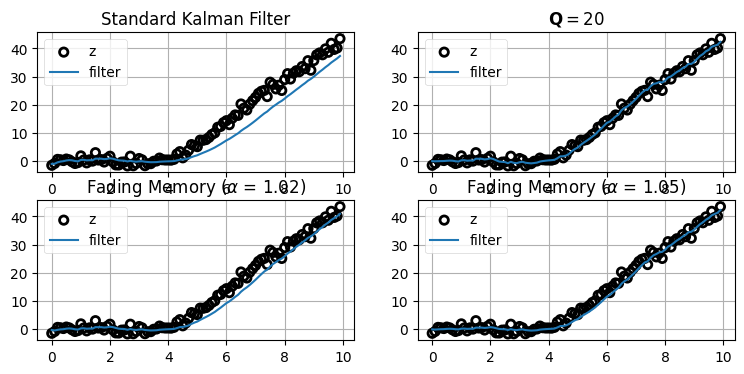

In [23]:
pos2, zs2 = generate_data(70, std=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

cvfilter = make_cv_filter(dt, std=1.2)
cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(221)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Standard Kalman Filter')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
    
xs = np.asarray(xs)

plt.subplot(222)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('$\mathbf{Q}=20$')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.02

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(223)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.02)')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.05

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(224)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.05)');

第一幅图展示了卡尔曼滤波器的性能。当机动开始时，滤波器发散，直到大约10秒后才重新获取信号。然后，我通过增大过程噪声，使滤波器迅速跟踪机动，但这会使滤波器的估计由于过度加权嘈杂的测量而变得非常嘈杂。接着，我实现了一个带有 $\alpha=1.02$ 的逐渐衰减记忆滤波器。滤波后的估计非常平滑，但在目标恢复稳定状态行为时，需要几秒钟才能收敛。然而，与卡尔曼滤波器相比，它的收敛时间要小得多，滞后量也要小得多——逐渐衰减滤波器的估计要比卡尔曼滤波器的估计更接近实际轨迹。最后，我将 $\alpha$ 提高到了1.05。在这里，我们可以看到滤波器对机动的响应几乎是即时的，但在稳定状态操作期间，估计并不像卡尔曼滤波器那样平稳，因为滤波器正在遗忘过去的测量。

这种如此小的代码更改所带来的性能表现相当不错！请注意，这里没有“正确”的选择。您需要根据您的需求以及测量噪声、过程噪声和目标机动行为的特性来设计您的滤波器。

# 多模型估计

在本章中使用的示例涉及一个目标以稳定状态移动，执行机动，然后回到稳定状态。我们将这视为两种模型——恒定速度模型和恒定加速度模型。每当您可以将系统描述为有限模型之一时，您可以使用*多模型（MM）估计*。我们使用多个滤波器组合，每个滤波器使用不同的过程来描述系统，并根据被跟踪对象的动态切换或混合它们。

正如您可能想象的那样，这是一个广泛的主题，有许多设计和实现多模型估计器的方法。但是考虑本章中跟踪的目标的一个简单方法。一个想法是同时运行恒定速度和恒定加速度滤波器，并在检测到机动时通过检查残差来在它们的输出之间进行切换。即使这个选择也给了我们许多选项。考虑一个转弯对象的动态。例如，汽车在轮距上转弯——前轮转动，汽车以后轮为轴心旋转。这是一个非线性过程，因此为了获得最佳结果，我们希望使用某种类型的非线性滤波器（EKF、UKF 等）来模拟转弯。另一方面，线性恒定速度滤波器在旅行的稳定状态部分表现良好。因此，我们的滤波器组可能包括线性KF和用于转弯的EKF滤波器。然而，这两种滤波器都不太适合模拟加速和制动等行为。因此，一个性能良好的多模型估计器可能包含许多滤波器组，每个滤波器组都设计用于跟踪对象特定性能范围内的最佳性能。

当然，您不需要基于模型的顺序来设计您的滤波器。您可以在每个滤波器中使用不同的噪声模型、不同的适配器。例如，在上面的部分中，我展示了许多图表，描述了改变参数对速度和位置估计的影响。也许某种设置对位置的效果更好，而另一种设置对速度更好。将两者放入您的滤波器组中。然后您可以从一个滤波器中获取位置的最佳估计，从另一个滤波器中获取速度的最佳估计。

# 一个双滤波自适应滤波器

我相信切换滤波器以获得最佳性能的想法是清晰的，但我们应该使用什么数学基础来实现它呢？我们面临的问题是通过嘈杂的测量来检测何时应该改变模型的情况。卡尔曼滤波器的哪个方面衡量了测量偏离预测的程度？是的，*残差*。

假设我们有一个一阶（恒定速度）卡尔曼滤波器。只要目标没有机动，滤波器将紧密跟踪其行为，大约 68% 的测量应该落在 1$\sigma$ 范围内。此外，残差应该围绕 0 波动，因为如果传感器是高斯的，正误差数量应该与负误差数量相等。如果残差增大并保持在预测边界之外，那么目标必定没有按照状态模型的预测进行。我们在这个图表中看到了这一点，在跟踪对象开始机动时，残差从围绕 0 变为突然跳跃并保持在零上方。

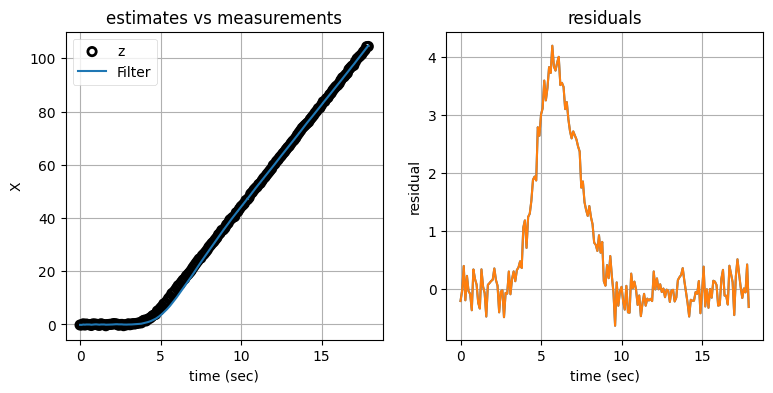

In [24]:
show_residual_chart()

对于这个问题，我们发现当物体处于稳定状态时，恒定速度滤波器的表现比恒定加速度滤波器更好，而在物体进行机动时情况正好相反。在上面的图表中，这个转变发生在4秒钟处。

因此，算法很简单。初始化一个恒定速度滤波器和一个恒定加速度滤波器，然后在预测/更新循环中同时运行它们。在每次更新后，检查恒定速度滤波器的残差。如果残差落在理论范围内，则使用恒定速度滤波器的估计作为最终估计，否则使用恒定加速度滤波器的估计。

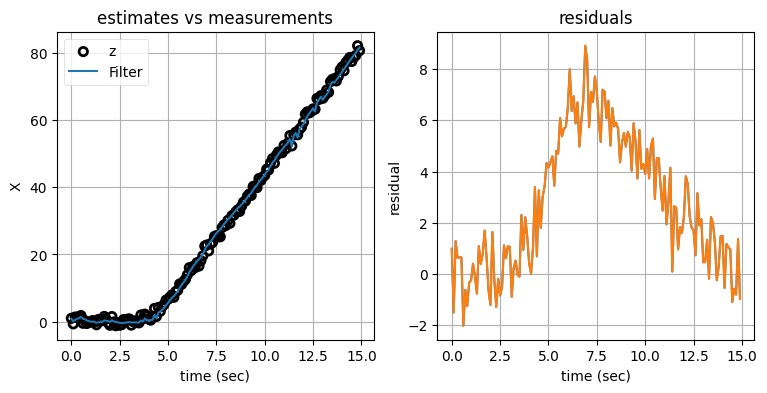

In [25]:
def run_filter_bank(threshold, show_zs=True):
    dt = 0.1
    cvfilter= make_cv_filter(dt, std=0.8)
    cafilter = make_ca_filter(dt, std=0.8)
    pos, zs = generate_data(120, std=0.8)
    z_xs = zs[:, 0]
    xs, res = [], []

    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        std = np.sqrt(cvfilter.R[0,0])
        if abs(cvfilter.y[0]) < 2 * std:
            xs.append(cvfilter.x[0])
        else:
            xs.append(cafilter.x[0])
        res.append(cvfilter.y[0])
    xs = np.asarray(xs)
    if show_zs:
        plot_track_and_residuals(dt, xs, z_xs, res)
    else:
        plot_track_and_residuals(dt, xs, None, res)

run_filter_bank(threshold=1.4)

这里的滤波器紧密跟踪了机动。当目标不进行机动时，我们的估计几乎没有噪音，一旦目标开始机动，我们很快就能检测到并切换到恒定加速度滤波器。然而，这并不是理想的。以下是单独绘制的滤波器输出：

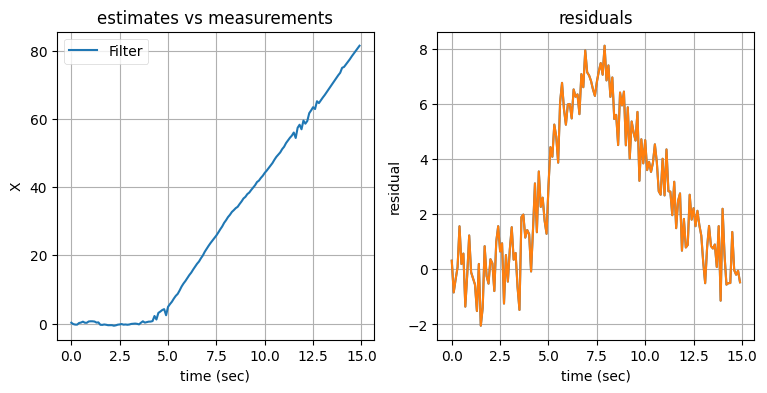

In [26]:
run_filter_bank(threshold=1.4, show_zs=False)

你可以看到当滤波器组从一个滤波器切换到另一个时，估计值会出现跳跃。我不会在生产系统中使用这个算法。下一节将提供一个最新的滤波器组实现，消除了这个问题。

# MMAE

这个使用多个滤波器来检测机动的核心思想是正确的，但在我们突然在滤波器之间进行转换时，估计值是不稳定的。在这本书中，我们使用概率来确定测量和模型的*可能性*时，选择一个滤波器而放弃另一个是违背了这个原则的。我们不是根据哪个更可能选择*测量*或*预测*，而是根据它们的可能性*混合*两者。我们应该在这里也采用相同的方法。这种方法称为*多模型自适应估计器*，或者 MMAE。

在**设计卡尔曼滤波器**章节中，我们学到了*可能性函数*

$$\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf{y}^\mathsf{T}\mathbf{S}^{-1}\mathbf{y}]$$

这告诉我们在给定输入情况下，一个滤波器执行得最好的可能性有多大。$\mathbf y$ 是残差，$\mathbf S$ 是系统不确定性（在测量空间中的协方差）。这仅仅是残差和系统不确定性的高斯函数。一个较大的残差将会导致较大的不确定性，从而使得该测量与滤波器当前状态相匹配的可能性降低。我们可以用这个函数来计算每个滤波器匹配数据的概率。如果我们有N个滤波器，我们可以计算第 i 个滤波器是正确的概率与其他滤波器的关系为：

$$p_k^i = \frac{\mathcal{L}_k^ip_{k-1}^i}{\sum\limits_{j=1}^N \mathcal{L}_k^jp_{k-1}^j}$$

看起来有点复杂，但实际上很简单。分子部分只是这一时刻的可能性乘以上一时刻该滤波器是正确的概率。我们需要所有滤波器的概率相加等于1，所以通过分母中的项来归一化所有其他滤波器的概率。

这是一个递归定义，因此我们需要为每个滤波器分配一些初始概率。在没有更好的信息的情况下，为每个滤波器使用 $\frac{1}{N}$。然后我们可以通过每个滤波器的状态乘以该滤波器的概率来计算估计状态。

下面是一个完整的实现：

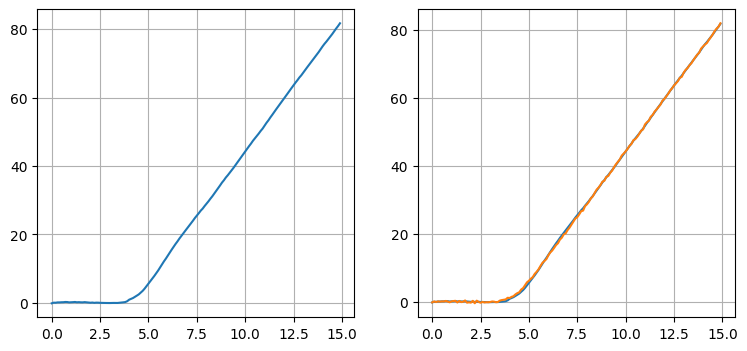

In [28]:
def run_filter_bank():
    dt = 0.1
    cvfilter = make_cv_filter(dt, std=0.2)
    cafilter = make_ca_filter(dt, std=0.2)

    _, zs = generate_data(120, std=0.2)
    z_xs = zs[:, 0]
    xs, probs = [], []

    pv, pa = 0.8, 0.2
    pvsum, pasum = 0., 0.
    
    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        cv_likelihood = cvfilter.likelihood * pv
        ca_likelihood = cafilter.likelihood * pa
        
        pv = (cv_likelihood) / (cv_likelihood + ca_likelihood)
        pa = (ca_likelihood) / (cv_likelihood + ca_likelihood)
        
        x = (pv * cvfilter.x[0]) + (pa*cafilter.x[0])
        xs.append(x)
        probs.append(pv / pa)

    xs = np.asarray(xs)
    t = np.arange(0, len(xs) * dt, dt)
    plt.subplot(121)
    plt.plot(t, xs)
    plt.subplot(122)
    plt.plot(t, xs)
    plt.plot(t, z_xs)
    return xs, probs

xs, probs = run_filter_bank()

我把滤波器的估计结果单独画在左边，这样你就可以看到结果的平滑程度。右边我同时画出了估计值和测量值，证明了滤波器正在追踪这个动作。

我想再次强调，这只不过是我们在整本书中一直使用的贝叶斯算法。我们有两个（或更多）测量或估计值，每个都有一个相关的概率。我们选择一个估计值，作为每个值的加权组合，权重与正确性的概率成比例。每一步概率的计算是根据贝叶斯定理进行的：

$$\frac{\texttt{Prob(meas | state)} \times\texttt{prior}}{\texttt{normalization}}$$

这就是贝叶斯定理。

在实际问题中，你可能需要在你的滤波器库中使用不止两个滤波器。在我的工作中，我使用计算机视觉来追踪物体。我追踪冰球。冰球滑动、弹跳和溜走，它们滚动、反弹，被拾起和携带，而且被运动员们迅速地“运球”。我追踪运动员，他们的非线性行为几乎是无限的。在这些情况下，只使用两个滤波器是不够的。我需要建立多个过程模型，对于计算机视觉检测引入的噪声有不同的假设等等。但是，你已经掌握了主要思想。

### MMAE滤波器的局限性

我所呈现的MMAE存在一个显著的问题。看看这个图表，显示了常速度和常加速度滤波器概率比值。

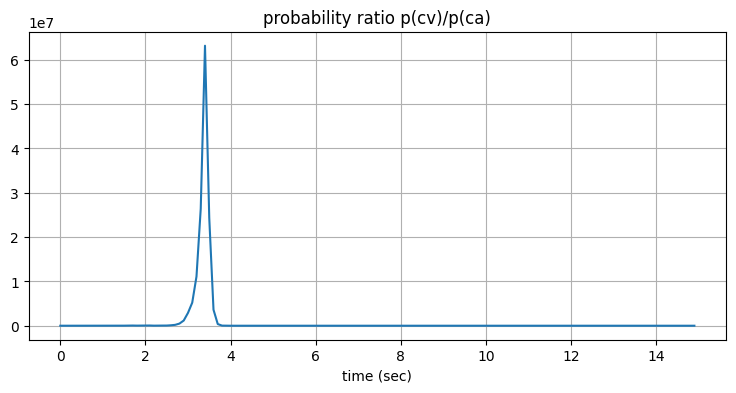

In [29]:
plt.plot(t[0:len(probs)], probs)
plt.title('probability ratio p(cv)/p(ca)')
plt.xlabel('time (sec)');

在最初的三秒钟，被追踪的物体直线运动时，常速度滤波器的概率远高于常加速度滤波器。一旦动作开始，概率迅速转变，更倾向于常加速度模型。然而，到第六秒动作已完成。你可能期望常速度滤波器的概率再次变大，但实际上它却保持为零。

这是因为概率的递归计算：

$$p_k = \frac{\mathcal{L}p_{k-1}}{\sum \text{probabilities}}$$

一旦概率变得非常小，就无法恢复。结果是，滤波器库迅速收敛于仅有最可能的滤波器。一个健壮的方案需要监控每个滤波器的概率，并淘汰那些概率非常低的滤波器，用那些更可能表现良好的滤波器取而代之。你可以将现有的滤波器细分为新的滤波器，试图涵盖使它们表现良好的特征。在最糟糕的情况下，如果一个滤波器偏离了轨道，你可以重新初始化一个滤波器的状态，使其更接近当前的测量值。

# 交互多个模型 (IMM)

让我们从另一个角度考虑多模型问题。场景与之前相同——我们希望追踪一个机动目标。我们可以设计一组卡尔曼滤波器，它们基于不同的建模假设。它们可以在滤波器阶数或过程模型中的噪声量方面有所不同。每当有新的测量数据进入时，每个滤波器都有成为正确模型的概率。

这种朴素的方法导致了组合爆炸。在第一步，我们产生了$N$个假设，即每个滤波器一个。在第二步，我们又产生了另外$N$个假设，然后需要将这些新假设与先前的$N$个假设组合，得到$N^2$个假设。许多不同的方案已经尝试过，它们要么剔除不太可能的假设，要么合并相似的假设，但这些算法仍然存在计算负担和/或性能不佳的问题。我在这本书中不会涉及这些，但文献中突出的例子是广义伪贝叶斯（GPB）算法。

*交互多模型*（IMM）算法是由Blom[5]提出，用来解决多模型的组合爆炸问题。Blom和Bar-Shalom的后续论文是最被引用的[6]。其思想是为系统的每种可能行为模式设定一个滤波器。在每个时刻，我们让这些滤波器*相互作用*。概率较高的滤波器会修改概率较低的滤波器的估计，使它们更接近系统的当前状态。这种融合是概率性的，因此不太可能的滤波器也会对概率较高的滤波器进行修改，但修改的程度要小得多。

举例来说，假设我们有两种模式：直行或转弯。每种模式都由一个卡尔曼滤波器表示，也许是一个一阶和二阶滤波器。现在假设目标在转弯。二阶滤波器会产生一个良好的估计值，而一阶滤波器会滞后信号。每个滤波器的似然函数告诉我们哪个滤波器最有可能。一阶滤波器的似然性很低，所以我们用二阶滤波器大幅调整其估计。二阶滤波器的概率很高，所以一阶卡尔曼滤波器只会对二阶滤波器做出轻微的调整。

现在假设目标停止转弯。因为我们一直在使用二阶滤波器的估计值来修正一阶滤波器的估计值，所以它不会滞后信号太多。在只经过几个时刻后，它将产生非常好（高似然性）的估计值，并成为最可能的滤波器。然后它将开始对二阶滤波器的估计值产生很大影响。请记住，二阶滤波器会将测量噪声误判为加速度。这种调整可以极大地减少这种效应。

# 众数概率

我们为系统定义了一组模式$m$，并假设目标始终处于这些模式中的一个。在上面的讨论中，我们有直行和转弯两种模式，因此$m=\{\text{直行},\ \text{转弯}\}$。

我们为目标处于任何给定模式的概率分配一个概率。这给了我们一个*模式概率*的向量，其中每种可能的模式都有一个概率。$m$有两种模式，所以我们将有一个包含两个概率的向量。如果我们认为目标有70%的可能是直行的，我们可以写成：

$$\mu = \begin{bmatrix} 0.7 & 0.3\end{bmatrix}$$

我们得到了0.3用于转弯，因为概率必须加起来为一。$\mu$通常但并非普遍被用作模式概率的符号，所以我会使用它。不要将其与均值混淆。

在Python中，我们可以这样实现：

In [30]:
mu = np.array([0.7, 0.3])
mu

array([0.7, 0.3])

我们可以通过以下方式形式化，即给定先前测量$Z$，$m_i$正确的先验概率（表示物体处于第$i$种模式）为

$$\mu_i = P(m_i|Z)$$

# 模式转换

接下来我们必须考虑这是一个机动目标。它会直行，然后转弯，然后再次直行。我们可以将这些模式之间的转换建模为一个[*马尔可夫链*](https://en.wikipedia.org/wiki/Markov_chain)，就像这个图示中的形式：

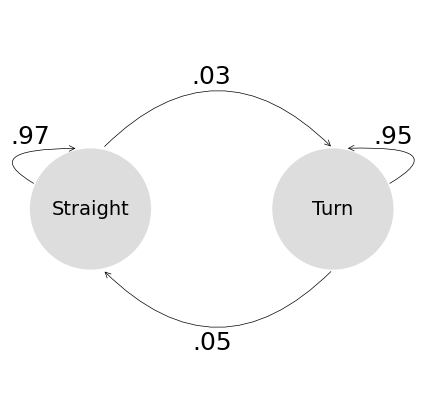

In [31]:
import kf_book.adaptive_internal as adaptive_internal
adaptive_internal.plot_markov_chain()

这显示了一个目标的两种模式示例，直行和转弯。如果目标当前处于直行模式，那么我们预测目标继续直行的概率为97%，开始转弯的概率为3%。一旦目标开始转弯，我们预测停留在转弯状态的概率为95%，回到直行路径的概率为5%。

算法对于确切数字不敏感，通常会使用模拟或试验来选择合适的值。然而，这些值相当具有代表性。

我们用一个[*转移概率矩阵*](https://en.wikipedia.org/wiki/Stochastic_matrix)来表示马尔可夫链，我们称之为$\mathbf M$。对于图示中的马尔可夫链，我们可以写成：

$$\mathbf M = \begin{bmatrix}.97 & .03\\.05 & .95\end{bmatrix}$$

换句话说，$\mathbf M[i, j]$是在上一个模式为$i$的情况下，当前模式为$j$的概率。在这个例子中，给定上一个模式是转弯$(i=1)$，当前模式是直行$(j=0)$的概率是$\mathbf M[1,\ 0] = 0.05$。在Python中我们可以这样写：

In [32]:
M = np.array([[.97, .03], [.05, .95]])
print(M)
print('From turn to straight probablility is', M[1, 0], 'percent')

[[0.97 0.03]
 [0.05 0.95]]
From turn to straight probablility is 0.05 percent


这让我们可以根据转移的概率计算新的模式概率。让我们计算在转移后目标处于直行模式的概率。有两种方式我们可以处于直行状态：一是之前一直直行，继续直行；二是之前转弯了，但接着又直行了。前者的概率是$(0.7\times 0.97)$，后者是$(0.3\times 0.05)$。我们将模式概率与马尔可夫链中的相关概率相乘。*总概率*是这两者的和，即$(0.7)(0.97) + (0.3)(0.05) = 0.694$。

回忆第二章中的[*全概率定理*](https://en.wikipedia.org/wiki/Law_of_total_probability)。它陈述了多个不同事件的概率为

$$P(A) = \sum P(A\mid B)\, P(B)$$

这里的$P(A\mid B)$是转移矩阵$\mathbf M$，$P(B)$是$\mu$。我们正在使用数组和矩阵，所以利用了向量乘以矩阵得到乘积之和的性质：

$$\begin{bmatrix}\mu_1 & \mu_2 \end{bmatrix}\begin{bmatrix}m_{11} & m_{12}\\m_{21} & m_{22}\end{bmatrix} = \begin{bmatrix}\mu_1 m_{11} + \mu_2 m_{21} & \mu_1 m_{12} + \mu_2 m_{22}\end{bmatrix}$$

IMM文献将此表示为

$$\bar c_j = \sum\limits_{i=1}^{N} \mu_i M_{ij}$$

我们使用NumPy的`dot`函数来计算这个过程。我们也可以使用矩阵乘法运算符`@`，但我觉得使用点乘符号更直观，因为它代表了求和运算符，即点积：

In [33]:
cbar = np.dot(mu, M)
cbar

array([0.694, 0.306])

# 计算众数概率

我们将使用贝叶斯定理计算新的模式概率。回忆一下贝叶斯定理陈述了：

$$\text{后验概率} = \frac{\text{先验概率} \cdot \text{似然性}}{\text{归一化因子}}$$

这里的先验概率是我们在上一节中计算的总概率。卡尔曼滤波器计算了*似然性*，即给定滤波器的当前状态，测量值的可能性。回顾一下方程：

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi \mathbf S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

在数学符号中，更新后的模式概率是：

$$\mu_i = \| \mathcal{L}_i {\bar c}_{i}\|$$

简言之，对于每个卡尔曼滤波器（模式），我们将当前模式的可能性考虑到可能的转移中，乘以这个模式是正确的概率。然后我们对所有概率进行归一化，使它们加起来为一。

在Python中这很容易计算。我会引入一个变量`L`来存储似然性。似然性是由`KalmanFilter.update()`步骤计算的，但在下面的代码段中，我只是硬编码了`L`的值，因为我们还没有创建卡尔曼滤波器：

In [34]:
# L = [kf0.L, kf1.L]  # get likelihoods from Kalman filters
L = [0.000134, 0.0000748] 
mu = cbar * L
mu /= sum(mu) # normalize
mu

array([0.802, 0.198])

这里可以看到，相对较强的直行滤波器的似然性将直行模式的概率从70%推高到了80.2%。

# 混合概率

这一步我们可以利用模式转移来计算所有可能选择的概率。如果 $\mu = \begin{bmatrix} 0.63 & 0.27\end{bmatrix}$，那么我们可以使用转移概率矩阵来计算所有可能的结果。换句话说，如果当前模式是直行$(\mu=0.63)$，我们可以根据目标是继续直行还是转弯计算出两个新的概率。对于转弯模式$(\mu=0.27)$也是同样的做法。我们将从2个模式概率变成4个。在下一步，4个将变成8个，依此类推。这在计算上是准确的，但在实践中是不可行的。仅仅经过30个时间步，你需要8GB的内存以双精度存储模式概率。

我们需要一个更好但近似的方法。IMM通过计算*混合概率*来解决这个问题。这个想法很简单。假设第一个模式（直行）当前非常可能，而第二个模式（转弯）不太可能。我们不是让直行模式的卡尔曼滤波器计算其状态为滤波器库中所有滤波器的加权平均值。与目标模式匹配概率高的滤波器权重比匹配概率低的滤波器更大。结果是来自可能滤波器的信息提高了不太可能的滤波器的准确性。这是算法的关键所在。

我们需要做的非常简单。每个卡尔曼滤波器执行更新步骤，计算一个新的均值和协方差。然后，我们根据*混合概率* $\omega$ 计算每个滤波器的新均值和协方差，作为这些均值和协方差的加权和。可能的滤波器会受到不太可能滤波器的轻微调整，而不太可能的滤波器会受到可能的滤波器的强烈调整。文献将这些调整后的均值和协方差称为*混合条件*或*混合初始条件*。我使用符号 $\mathbf x^m_j$ 表示混合状态，$\mathbf P^m_j$ 表示混合协方差。方程如下：

$$\begin{aligned}
\mathbf x^m_j &= \sum_{i=1}^N \omega_{ij} \mathbf x_i \\
\mathbf P^m_j &= \sum_{i=1}^N \omega_{ij}\left[(\mathbf x^i - \mathbf  x^m_i) (\mathbf x^i - \mathbf  x^m_i)^\mathsf T + \mathbf P_i\right]
\end{aligned}$$

把下标看作数组的索引即可理解。用伪Python语言表示，我们可以写成这样：

```python
for j in N:
    x0[j] = sum_over_i(w[i, j] * x[i])
    P0[j] = sum_over_i(w[i, j] * (P[i] + np.outer(x[i] - x0[j])))
```

不要让符号混淆了一个简单的概念：将可能滤波器的估计值合并到不太可能滤波器的估计值中，确保所有估计值都比较准确。

我们如何计算混合概率？思考一下，在阅读下文之前尝试给出一个合理的答案。我们有描述每个模式当前概率的模式概率，然后是描述改变模式可能性的转换概率。如何计算新的概率？

当然是贝叶斯定理！先验乘以似然，再进行归一化。先验是模式概率，似然来自马尔可夫链，我们把它存储在矩阵$\mathbf M$中。

$$\boldsymbol\omega_{ij} = \| \mu_i \cdot \mathbf M_{ij}\|$$

我们可以这样计算。我上面的$\mu$和$\bar c$的更新顺序错了（你必须将转换概率矩阵纳入$\mu$来计算$\bar c$），所以我需要在这里纠正一下：

In [35]:
cbar = np.dot(mu, M) #compute total probability that target is in mode j

omega = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        omega[i, j] = (M[i, j] * mu[i]) / cbar[j]
omega

array([[0.987, 0.114],
       [0.013, 0.886]])

卡尔曼滤波器需要执行预测步骤来计算新的先验值。它们使用混合的估计值：

$$
\begin{aligned}
\bar{\mathbf x}_j &= \mathbf F_j\mathbf x^m_j\\
\bar{\mathbf P}_j &= \mathbf F_j\mathbf P^m_j\mathbf F_j^\mathsf T + \mathbf Q_j
\end{aligned}$$

# IMM估计

现在我们需要从滤波器组中得到最终的状态估计。我们应该怎么做呢？只需给每个卡尔曼滤波器的混合估计加权即可：

$$\begin{aligned}
\mathbf x &= \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j\\
\mathbf P &= \sum_{j=1}^N \mu_j\left[(\bar{{\mathbf x}}_j - \bar{\mathbf x})({\bar{\mathbf x}}_j - \bar{\mathbf x})^\mathsf T + \bar{\mathbf P_j}\right]
\end{aligned}$$

# 使用 IMM 跟踪机动目标

让我们来做一个例子。Crassidis[4]中有一个经过解答的例子，所以我选择了他的例子。他跟踪一个移动目标600秒。目标开始时直线运动，然后在400秒开始注入控制输入，导致目标转向90度。他使用了两个恒定加速度卡尔曼滤波器。一个滤波器假设没有过程噪声，另一个假设过程噪声的谱密度为$10^{-3}\mathbf I$。他假设对滤波器有很好的初始化，将$\mathbf P$设置为$10^{-12}$。我的实现如下：

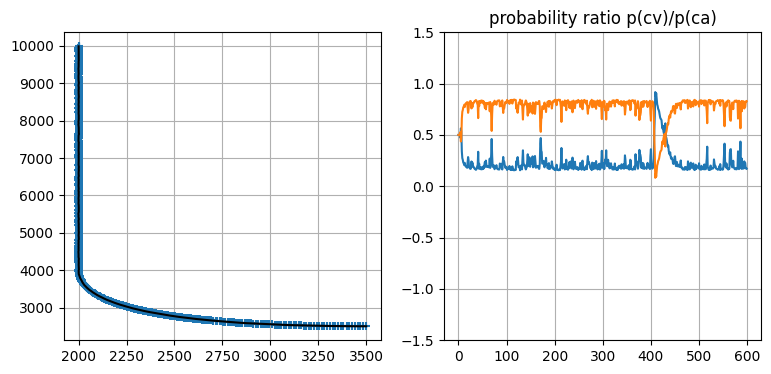

In [36]:
import copy
from scipy.linalg import block_diag
from filterpy.kalman import IMMEstimator
from filterpy.common import Saver

N = 600
dt = 1.
imm_track = adaptive_internal.turning_target(N)

# create noisy measurements
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + randn()*r
    zs[i, 1] = imm_track[i, 2] + randn()*r

ca = KalmanFilter(6, 2)
dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
            
ca.F = block_diag(F, F)
ca.x = np.array([[2000., 0, 0, 10000, -15, 0]]).T
ca.P *= 1.e-12
ca.R *= r**2
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-3
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

# create identical filter, but with no process error
cano = copy.deepcopy(ca)
cano.Q *= 0

filters = [ca, cano]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

xs, probs = [], []
for i, z in enumerate(zs):
    z = np.array([z]).T
    bank.predict()
    bank.update(z)

    xs.append(bank.x.copy())
    probs.append(bank.mu.copy())

xs = np.array(xs)
probs = np.array(probs)
plt.subplot(121)
plt.plot(xs[:, 0], xs[:, 3], 'k')
plt.scatter(zs[:, 0], zs[:, 1], marker='+')

plt.subplot(122)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.ylim(-1.5, 1.5)
plt.title('probability ratio p(cv)/p(ca)');

让我们来看一下滤波器的性能，特别是转弯开始的时候。我调换了$x$和$y$轴，以便我们能够更近距离地观察。在下面的图表中，转弯发生在$Y=4000$。如果你仔细观察，你可以看到在转弯开始后估计值稍微波动了一下，但滤波器没有滞后，很快就平稳地跟踪了测量值。

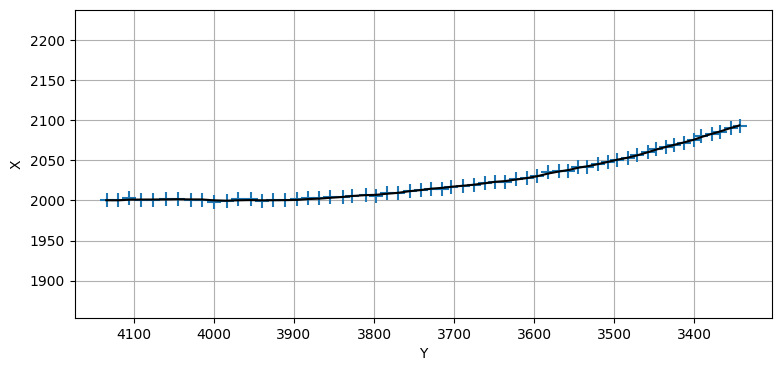

In [37]:
plt.plot(xs[390:450, 3], xs[390:450, 0], 'k')
plt.scatter(zs[390:450, 1], zs[390:450, 0], marker='+', s=100);
plt.xlabel('Y'); plt.ylabel('X')
plt.gca().invert_xaxis()
plt.axis('equal');


# IMM 的局限性

我对IMM的工作并不是特别了解，所以我无法像我希望的那样详细解释这个问题。然而，IMM的发明是为了跟踪机动飞行器进行空中交通管制，据说在那个角色中表现非常出色。

这个使用案例假设了一些条件。其中最重要的是，滤波器组中的所有滤波器必须具有相同的维度设计。仔细审查数学原理可以解释为什么会这样。为了创建混合估计，IMM执行以下计算：

$$\mathbf x = \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j$$

只有在每个滤波器中状态$x$的维度相同的情况下，才能进行计算。此外，$x[i]$的解释在每个滤波器中必须是相同的。

例如，假设我们尝试使用一个使用恒定速度模型的滤波器和另一个使用恒定加速度模型的滤波器。这是行不通的，因为$x$的维度是不同的。如果尝试使用具有不同维度的滤波器，`FilterPy`会引发`ValueError`错误。

In [38]:
ca = KalmanFilter(3, 1)
cv = KalmanFilter(2, 1)

trans = np.array([[0.97, 0.03],
                  [0.03, 0.97]])

imm = IMMEstimator([ca, cv], (0.5, 0.5), trans)

ValueError: All filters must have the same state dimension

这是一个复杂的问题。在处理IMM时，确保所有滤波器具有相同的状态维度和相似的状态解释非常重要。如果不同滤波器的状态维度或解释不同，将会导致混合估计出现问题。

过去，我曾建议设计具有恒定速度的滤波器维度为3，并且实现`F`矩阵以忽略加速度：

```python
F = np.array([[1, dt, 0],
              [0, 1,  0],
              [0, 0,  0]])
```

回想起来，我不确定这是否是一个合理的建议。虽然这使得IMM可以工作，但很明显，对于加速度的估计将是不正确的，因为一个滤波器将有一个准确的加速度估计，而另一个滤波器将有一个0的估计。这不准确的加速度然后会被用来执行下一个预测周期。

再考虑一个更极端的情况。假设你的某个滤波器将`x[2]`解释为加速度，而另一个滤波器将其解释为角速度。显然，混合估计中的`x[2]`将毫无意义，因为你不能将（线性）加速度与旋转速率进行简单求和。

我对IMM了解不是特别深入。也许相关文献解释了如何处理这些情况。我能说的是，FilterPy实现的IMM对这些用例是无法正常工作的。

用于空中交通管制的IMM设计使用具有不同过程假设的滤波器。一架飞机可以是水平飞行，可以下降/上升，可以进行协调转弯或非协调转弯。你可以为每种情况设计一个具有不同`F`和`Q`矩阵的滤波器，但所有情况下的状态估计`x`将是相同的。

# 总结

这一章包含了本书中较为具有挑战性的内容。然而，它是实现逼真的卡尔曼滤波器的入口。如果我们控制一个机器人，我们知道它的过程模型，构建一个针对它的卡尔曼滤波器就很容易。但更常见的情况是，我们拿到一组时间序列数据，并被要求理解它。对于我们来说，过程模型在很大程度上是未知的。我们使用本章的技术来*学习*（在机器学习的意义上）如何参数化我们的模型。随着目标的机动性变化，模型也随之改变，因此我们的滤波器必须是自适应的。

寻找最优解涉及到组合爆炸，在实践中是不切实际的。IMM算法因其良好的性能和计算可行性而成为标准算法。

一个真实的滤波器组通常不止包含两个滤波器。通常会有许多滤波器。随着目标状态的变化，一些滤波器变得极不可能。大多数自适应滤波器实现了一个算法，用于淘汰极不可能的滤波器，并用更符合当前状态的滤波器替换它们。这高度依赖于你的问题领域，并且通常是非常临时的。你需要设计一些杀死和创建滤波器的方案，并用模拟或真实数据进行测试。

尽管算法复杂，但我希望你能认识到其中的基本思想是非常简单的。我们使用了第二章学到的两个工具：贝叶斯定理和全概率定理。我们使用贝叶斯定理来整合新信息，并使用全概率定理计算过程模型的影响。

对我来说，这一章强调了贝叶斯卡尔曼滤波器的美妙之处。我并不是特别在意你是否学会了IMM算法的细节。但我希望你能看到，非常简单的概率推理导致了这些结果。卡尔曼博士导出的线性代数方程来自一种称为*正交投影*的不同推理形式。它在某种程度上也是美丽的，并且我建议你阅读他的论文。但我不确定我是否觉得这些方程在使用时直观，并且如何使用这些技术设计新的非最优滤波器，比如IMM，也不是很清楚。相比之下，贝叶斯定理让我们能够轻松处理这些问题。

# 参考

* [1] Bar-Shalom, Y., Xiao-Rong L., and Thiagalingam Kirubarajan. *Estimation with Applications to Tracking and Navigation*. New York: Wiley, p. 424, 2001. 


* [2] Zarchan, P., and Musoff, H., *Fundamentals of Kalman Filtering: A Practical Approach* Fourth Edition. Reston, VA: American Institute of Aeronautics and Astronautics, p.584-595, 2015. 


* [3] Simon, D., *Optimal State Estimation: Kalman, H and Nonlinear Approaches*. Hoboken, NJ: Wiley-Interscience, p. 208-212, 2006


* [4] Crassidis, John L., and John L. Junkins. *Optimal estimation of dynamic systems*. CRC press, 2011.


* [5] Blom, H.A.P., "An Efficient Filter for Abruptly Changing Systems", *Proceedings of 23rd Conference on Decision and Control*, Las Vegas, NV, Dec 1984.


* [6] Blom, H.A.P and Bar-Shalom, Y., "The Interacting Multiple Model Algorithm for Systems with Markovian Switching Coefficients", *IEEE Transactions on Automatic Control*, Vol. AC-8, No. 8, Aug. 1998, pp. 780-783.